In [1]:
import os
import sys

from pathlib import Path

import numpy as np
import pandas as pd
import math
from math import exp

import scipy
from sklearn import linear_model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.insert(0, os.path.join('.', '..', '..', 'calibration'))

In [7]:
import thermodynamics
from postprocessing import *
from CoolProp.HumidAirProp import HAPropsSI

In [4]:
%load_ext autoreload
# only reload the function imported by "aimport"
%autoreload 1
%aimport thermodynamics, postprocessing, plotting, calibration_MgCl2_class

## check validity of regression method scipy using Chen's data and input parameter (Re, Pr, etc.) read from Modelica
- results: the scipy regression performed well, seems like Chen used this method to generate the equation

In [5]:
obj = EnBA_M_post_processing("","")

In [10]:
df_input = obj.generate_regression_input('../table_for_regression/chen_original_data.csv', if_log=False, )

number of cooling datapoint is 15 

following datasets are excluded from regression: 
 set().
no Nu_2 and Sh_2 in dataframe.
###### use unsorted calibration data ######


In [11]:
df_input.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,x_d_in_equ,m_d_in,T_a_o_exp,T_d_o_exp,x_a_o_exp,Re,Pr,Sc,Nu,Sh
1,298.75,0.0162,1.85,288.05,0.2300,0.006324,2.61,292.35,294.45,0.0091,987.281738,0.722571,0.655760,3.860095,3.025952
10,297.15,0.0152,1.94,289.95,0.2961,0.004830,2.82,293.25,296.25,0.0075,1039.711548,0.722219,0.659328,4.838657,3.252444
11,297.35,0.0160,1.98,290.85,0.3007,0.004961,2.85,294.05,297.05,0.0077,1060.585449,0.722659,0.658880,5.198952,3.377879
12,298.25,0.0152,1.94,291.25,0.3052,0.004929,2.90,294.45,297.25,0.0075,1036.682617,0.722056,0.656871,4.696949,3.327239
13,298.35,0.0143,1.95,290.95,0.3182,0.004380,2.85,294.25,297.05,0.0069,1041.750488,0.721513,0.656648,4.911287,3.229478


In [16]:
popt= obj.regr_via_scipy(df=df_input, target='Nu')

In [54]:
popt

array([51.12379578,  1.79360145,  0.33329819, -1.00099958,  0.81979939,
        0.38460022])

In [18]:
results_from_regr = obj.func_Nu(df_input, *popt)

In [20]:
obj.calc_R_squared(data_ref=df_input['Nu'], data_cal=results_from_regr)

0.9999999999994523

In [22]:
popt2 = obj.regr_via_scipy(df=df_input, target='Sh', iter_num=20000)

In [55]:
popt2

array([13.16754741,  2.15760117,  0.33330206,  0.52349915, -0.8956009 ,
        0.23760046])

In [24]:
results_from_regr_Sh = obj.func_Sh(df_input, *popt2)

In [26]:
obj.calc_R_squared(data_ref=df_input['Sh'], data_cal=results_from_regr_Sh)

0.999999999996936

## check if it possible to get a proper formular to reproduce the Nu Sh generated by iteration
- result: cannot generate a formula which agrees well with the iterated value, but the R square seems to be in an acceptable range.
- sigma didn't contribute much to the result accuracy

**prepare data**

In [32]:
obj = EnBA_M_post_processing("","")

In [28]:
df_ori = pd.read_csv('../table_for_regression/final_output_calib.csv', index_col=0)

In [29]:
df_ori.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,x_a_o_exp,T_d_o_exp,xi_d_o_exp,...,T_d_o_sim_new,xi_d_o_sim_new,xi_d_out,x_d_in_equ,Re,Pr,Sc,epsilon_w,epsilon_T,epsilon_h
1,298.75,0.0162,1.85,288.05,0.2300,2.61,292.35,0.0091,294.45,0.2288,...,293.403503,0.228852,0.228848,0.007228,996.698754,0.723822,0.616835,0.791362,0.598131,0.729568
10,297.15,0.0152,1.94,289.95,0.2961,2.82,293.25,0.0075,296.25,0.2945,...,295.260590,0.294550,0.294540,0.006049,1048.989749,0.722987,0.616519,0.841421,0.541667,0.769997
11,297.35,0.0160,1.98,290.85,0.3007,2.85,294.05,0.0077,297.05,0.2990,...,297.783600,0.298635,0.298976,0.006254,1070.471776,0.723793,0.616603,0.851667,0.507692,0.779476
12,298.25,0.0152,1.94,291.25,0.3052,2.90,294.45,0.0075,297.25,0.3036,...,296.483215,0.303637,0.303636,0.006259,1046.027445,0.722846,0.616694,0.861220,0.542857,0.785601
13,298.35,0.0143,1.95,290.95,0.3182,2.85,294.25,0.0069,297.05,0.3166,...,296.302978,0.316595,0.316597,0.005690,1050.698532,0.721900,0.616654,0.859495,0.554054,0.781746


In [30]:
df_selected = df_ori[['T_a_in', 'x_a_in', 'm_a_in', 'T_d_in', "xi_d_in", 'x_d_in_equ', 'm_d_in', 'Re', 'Pr', 'Sc', 'Nu_iter', 'Sh_iter']]

In [31]:
dict_rename = {'Nu_iter':'Nu',
              'Sh_iter':'Sh',}
df_selected = df_selected.rename(columns = dict_rename)
df_selected.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,x_d_in_equ,m_d_in,Re,Pr,Sc,Nu,Sh
1,298.75,0.0162,1.85,288.05,0.2300,0.007228,2.61,996.698754,0.723822,0.616835,3.662364,3.251291
10,297.15,0.0152,1.94,289.95,0.2961,0.006049,2.82,1048.989749,0.722987,0.616519,4.363029,3.334007
11,297.35,0.0160,1.98,290.85,0.3007,0.006254,2.85,1070.471776,0.723793,0.616603,5.023988,3.700249
12,298.25,0.0152,1.94,291.25,0.3052,0.006259,2.90,1046.027445,0.722846,0.616694,4.487529,3.472546
13,298.35,0.0143,1.95,290.95,0.3182,0.005690,2.85,1050.698532,0.721900,0.616654,4.655537,3.399286


In [64]:
# df_selected.to_csv('cleaned_calib.csv')

#### **regression**

In [33]:
df_input = obj.generate_regression_input('../table_for_regression/cleaned_calib.csv', if_log=False, )

number of cooling datapoint is 15 

following datasets are excluded from regression: 
 set().
no Nu_2 and Sh_2 in dataframe.
###### use unsorted calibration data ######


In [34]:
df_input.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,x_d_in_equ,m_d_in,T_a_o_exp,T_d_o_exp,x_a_o_exp,Re,Pr,Sc,Nu,Sh
1,298.75,0.0162,1.85,288.05,0.2300,0.007228,2.61,292.35,294.45,0.0091,996.698754,0.723822,0.616835,3.662364,3.251291
10,297.15,0.0152,1.94,289.95,0.2961,0.006049,2.82,293.25,296.25,0.0075,1048.989749,0.722987,0.616519,4.363029,3.334007
11,297.35,0.0160,1.98,290.85,0.3007,0.006254,2.85,294.05,297.05,0.0077,1070.471776,0.723793,0.616603,5.023988,3.700249
12,298.25,0.0152,1.94,291.25,0.3052,0.006259,2.90,294.45,297.25,0.0075,1046.027445,0.722846,0.616694,4.487529,3.472546
13,298.35,0.0143,1.95,290.95,0.3182,0.005690,2.85,294.25,297.05,0.0069,1050.698532,0.721900,0.616654,4.655537,3.399286


**Nu**

In [37]:
# without considering uncertainty
popt_Nu0 = obj.regr_via_scipy(df=df_input, target='Nu', sigma_ratio=None, abs_sigma=True, iter_num=20000, method='lm')

In [38]:
popt_Nu0

array([ 8.22184219e-03, -2.70145023e-02, -2.53090348e+01, -2.26669746e+00,
        1.54496894e+00,  7.70895418e-01])

In [40]:
results_from_regr_Nu0 = obj.func_Nu(df_input, *popt_Nu0)
obj.calc_R_squared(data_ref=df_input['Nu'], data_cal=results_from_regr_Nu0)

0.8953210566682792

In [42]:
# with considering uncertainty
popt_Nu1 = obj.regr_via_scipy(df=df_input, target='Nu', sigma_ratio=0.2, abs_sigma=True, iter_num=20000, method='lm')

In [43]:
popt_Nu1

array([ 3.63188299e-03, -1.98779143e-01, -2.77892903e+01, -2.47621235e+00,
        1.61056350e+00,  8.05956340e-01])

In [45]:
results_from_regr_Nu1 = obj.func_Nu(df_input, *popt_Nu1)
obj.calc_R_squared(data_ref=df_input['Nu'], data_cal=results_from_regr_Nu1)

0.8939304819055519

In [51]:
df_input['Nu_0'] = results_from_regr_Nu0
df_input['Nu_1'] = results_from_regr_Nu1

**Sh**

In [46]:
# without uncertainty
popt_Sh0 = obj.regr_via_scipy(df=df_input, target='Sh', sigma_ratio=None, abs_sigma=True, iter_num=20000)
results_from_regr_Sh0 = obj.func_Sh(df_input, *popt_Sh0)
obj.calc_R_squared(data_ref=df_input['Sh'], data_cal=results_from_regr_Sh0)

0.5651517258398246

In [48]:
# with uncertainty = 0.2 Sh
popt_Sh1 = obj.regr_via_scipy(df=df_input, target='Sh', sigma_ratio=0.2, abs_sigma=True, iter_num=20000)
results_from_regr_Sh1 = obj.func_Sh(df_input, *popt_Sh1)
obj.calc_R_squared(data_ref=df_input['Sh'], data_cal=results_from_regr_Sh1)

0.5475416164281974

In [49]:
df_input['Sh_0'] = results_from_regr_Sh0
df_input['Sh_1'] = results_from_regr_Sh1

In [46]:
# df_input.to_csv('regression_chen.csv')

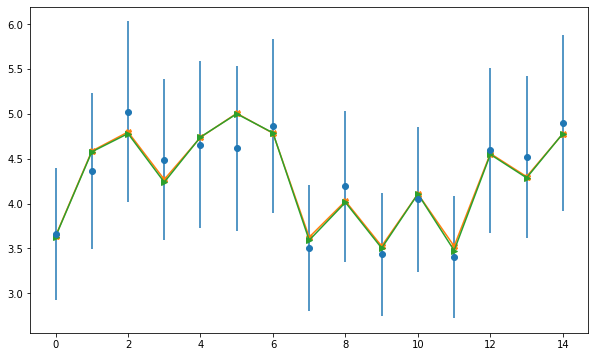

In [52]:
# error bar plot of Nu
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(df_input.reset_index().index, df_input.reset_index()['Nu'], df_input.reset_index()['Nu']*0.2, fmt = 'o')
ax.plot(df_input.reset_index().index, df_input.reset_index()['Nu_0'], marker = 'X')
ax.plot(df_input.reset_index().index, df_input.reset_index()['Nu_1'], marker = '>')

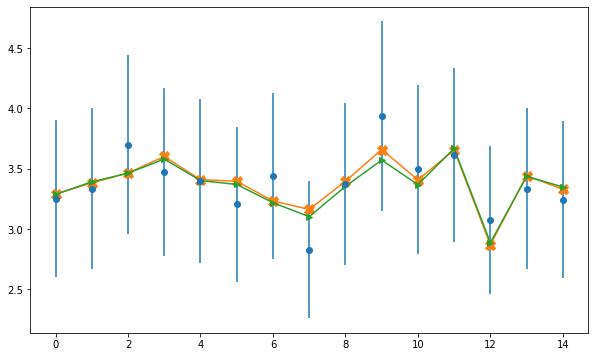

In [53]:
# error bar plot of Sh
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(df_input.reset_index().index, df_input.reset_index()['Sh'], df_input.reset_index()['Sh']*0.2, fmt = 'o')
ax.plot(df_input.reset_index().index, df_input.reset_index()['Sh_0'], marker = 'X', markersize = 10)
ax.plot(df_input.reset_index().index, df_input.reset_index()['Sh_1'], marker = '>')